In [32]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import Adam
# from keras.layers.recurrent import LSTM
from keras_tqdm import TQDMNotebookCallback

%matplotlib inline
import mpld3
mpld3.enable_notebook()

In [2]:
from ipywidgets import interact

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

In [3]:
# loading data

data= pd.read_csv('preprocessed2.csv')

In [4]:
data.head()

,Unnamed: 0,uuid,src_site_data center a,src_site_data center b,src_site_data center c,src_site_data center d,src_site_data center e,dst_site_data center a,dst_site_data center b,dst_site_data center c,dst_site_data center d,dst_site_data center e,bytes,event_type_x_transfer-success,event_type_x_transfer-failure,time_taken
0,0,ebbf565d-7e70-4677-9f07-b08d72051ddb,0,0,1,0,0,0,0,0,0,1,8940116437,1,0,8797.0
1,1,3ba82468-6516-4d6f-883c-1ac1108c3d89,0,1,0,0,0,0,0,1,0,0,1288661369,1,0,6568.0
2,2,22b1ff08-a2ec-427e-b53b-fea91787e7b5,0,1,0,0,0,0,0,0,1,0,4230378729,1,0,8638.0
3,3,713aabb7-0cfd-4b3e-a1ad-9de5fbb6ac50,0,0,0,1,0,1,0,0,0,0,8116545364,1,0,8372.0
4,4,3395b5c9-fee0-4dbd-ac0b-5e2ffc59d4b3,1,0,0,0,0,0,0,0,0,1,5182557683,1,0,8305.0


### Normailizing the inputs:

* All the variables except the file size are already suitably scaled. Therefore there isn't any need to use a library like scikit-learn to scale the entire dataset.
* Normalizing the file size to values between 0 and 1.

In [5]:
max, min=data['bytes'].max(),data['bytes'].min()

data['bytes']= (data['bytes'] - min) / max

data= data.drop(['Unnamed: 0'], axis=1)
data.head()

,uuid,src_site_data center a,src_site_data center b,src_site_data center c,src_site_data center d,src_site_data center e,dst_site_data center a,dst_site_data center b,dst_site_data center c,dst_site_data center d,dst_site_data center e,bytes,event_type_x_transfer-success,event_type_x_transfer-failure,time_taken
0,ebbf565d-7e70-4677-9f07-b08d72051ddb,0,0,1,0,0,0,0,0,0,1,0.894012,1,0,8797.0
1,3ba82468-6516-4d6f-883c-1ac1108c3d89,0,1,0,0,0,0,0,1,0,0,0.128865,1,0,6568.0
2,22b1ff08-a2ec-427e-b53b-fea91787e7b5,0,1,0,0,0,0,0,0,1,0,0.423037,1,0,8638.0
3,713aabb7-0cfd-4b3e-a1ad-9de5fbb6ac50,0,0,0,1,0,1,0,0,0,0,0.811655,1,0,8372.0
4,3395b5c9-fee0-4dbd-ac0b-5e2ffc59d4b3,1,0,0,0,0,0,0,0,0,1,0.518255,1,0,8305.0


In [6]:
data.shape

(1000000, 15)

In [7]:
model_data = np.array(data.drop('uuid',axis=1))
model_data.shape

(1000000, 14)

In [8]:
model_data.shape[0]

1000000

### Splitting the training and testing data : 80:20 ratio

In [9]:
train_fraction = 0.8
data_size = model_data.shape[0]
split_index = int(train_fraction * data_size)
# print(split_index)
trainX,trainY, testX,testY = model_data[:split_index,:13],model_data[:split_index,13],model_data[split_index:,:13],model_data[split_index:,13]

In [10]:
trainX.shape

(800000, 13)

In [11]:
trainY.shape

(800000,)

# Building and compiling the neural network

In [12]:
import keras.callbacks as cb

class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)

In [33]:
def init_model():
    start_time= time.time()
    print('Compiling model ...')
    
    model = Sequential()
    model.add(Dense(512, input_dim=13,init='normal', activation='tanh'))

    model.add(Dense(512,init='normal', activation='linear'))
    model.add(LeakyReLU(alpha=0.001))

    model.add(Dense(512, init='normal', activation='tanh'))
    model.add(Dense(256, init='normal', activation='relu'))
    # model.add(LeakyReLU(alpha=0.001))

    model.add(Dense(256, init='normal', activation='linear'))
    model.add(Dense(128, init='normal', activation='relu'))
    model.add(Dense(1))
    
    adam = Adam(lr=0.0001)
    model.compile(loss='mean_squared_error', optimizer=adam, metric=['mean_squared_error'])
    print('Model compield in {0} seconds'.format(time.time() - start_time))
    return model

In [34]:
def run_network(model=None, epochs=20, batch=256):
    try:
        start_time = time.time()

        if model is None:
            model = init_model()

        history = LossHistory()

        print('Training model...')
        training = model.fit(trainX, trainY, nb_epoch=epochs, batch_size=batch,
                             callbacks=[history, TQDMNotebookCallback(leave_inner=True)],
                             validation_split=0.1, verbose=0)

        print("Training duration : {0}".format(time.time() - start_time))
        score = model.evaluate(trainX, trainY, verbose=0)

        print("Network's training score [MSE]: {0}".format(score))
        print("Training finished !!!!!!")
        return training, model, history.losses
    except KeyboardInterrupt:
        print('KeyboardInterrupt')
        return model, history.losses

In [35]:
def plot_losses(losses):
    sns.set_context('poster')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(losses)
    ax.set_title('Loss per batch')
    fig.show()
    print(len(losses))

## Training the neural net on training data set

### Validation set = 10 % of training data i.e. 100,000 data points

Compiling model ...
Model compield in 0.08396530151367188 seconds
Training model...


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:1960: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))



Training duration : 134.87011528015137
Network's training score [MSE]: 263072.7330890625
Training finished !!!!!!
7040


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


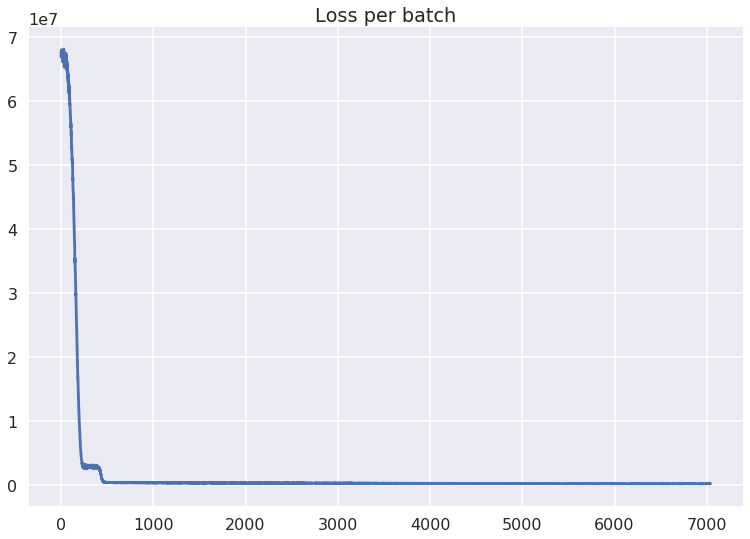

In [37]:
training, model, losses = run_network(epochs= 20, batch=2048)
plot_losses(losses)

In [38]:
print(training.history.keys())

dict_keys(['loss', 'val_loss'])


## Plotting the training and validation error

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


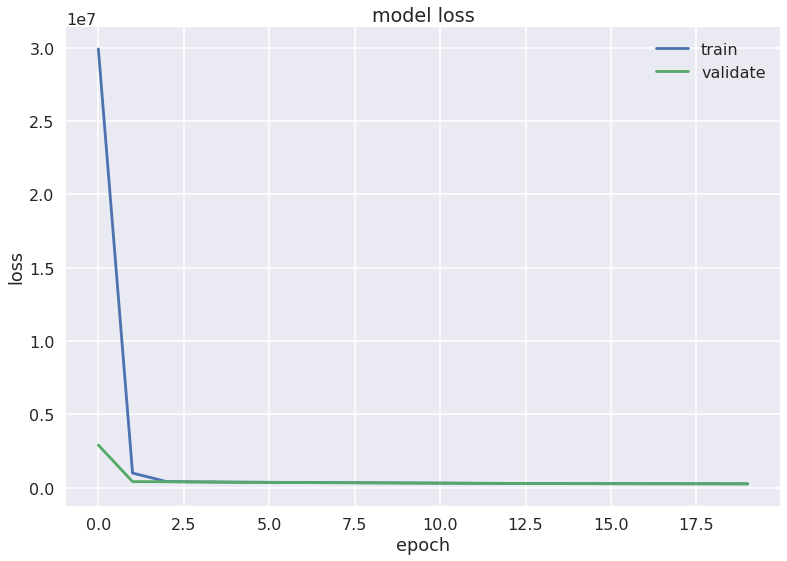

In [39]:
sns.set_context('poster')

plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

# Evaluating the model on unseen test data

In [40]:
score = model.evaluate(testX, testY, verbose=2)

### Model Test accuracy ( metric used : Mean Squared Error )

In [41]:
print('Results: MSE - {:.6f}  ;  seconds = {:.3f}'.format(score, np.sqrt(score)))

Results: MSE - 264866.821514  ;  seconds = 514.652


### Visualizing prediction values

In [42]:
predictions=model.predict(testX[:1000,:])

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:1960: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


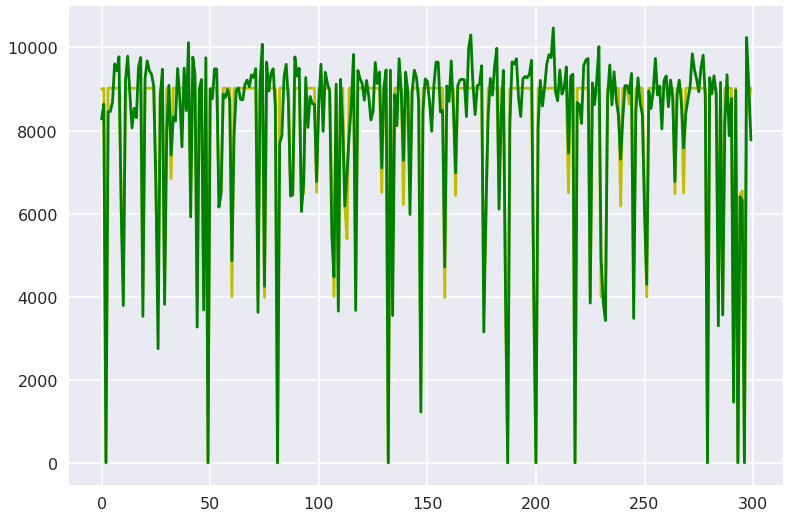

In [43]:
sns.set_context('poster')

# plotting a portion of the test values against the predicted output

plt.plot(predictions[:300,0],'y' )
plt.plot(testY[:300], 'g')

plt.show()

### Isolating the output and test to compare

In [44]:
p = figure(plot_width=950, plot_height=500)
p.line(x=list(range(len(predictions[:200,0]))), y=predictions[:200,0], color='#008000')
show(p)

q = figure(plot_width=950, plot_height=500)
q.line(x=list(range(len(predictions[:200,0]))), y=testY[:200])
show(q)

## Conclusion